In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn .metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn .metrics import accuracy_score
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option("display.max.columns", None)

df = pd.read_csv("train.csv",sep = "," , encoding = "utf-8")
df_test = pd.read_csv("test.csv",sep = "," , encoding = "utf-8")

In [3]:
df.shape , df_test.shape

((100000, 28), (50000, 27))

In [4]:
missing_values_df=df.isna().sum()
missing_values_df

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

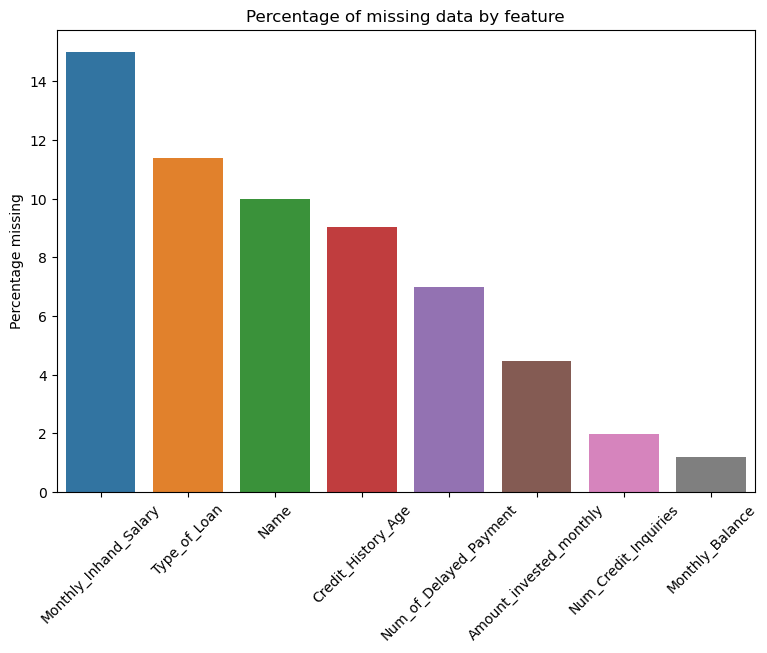

In [5]:
df_na = (missing_values_df / len(df)) * 100

# drop columns without missing values 
df_na = df_na.drop(df_na[df_na == 0].index)

#sort
df_na=df_na.sort_values(ascending=False)

# create plot
f, ax = plt.subplots(figsize=(9, 6))
plt.xticks(rotation='45')
sns.barplot(x=df_na.index, y=df_na)
ax.set(title='Percentage of missing data by feature', ylabel='Percentage missing')
plt.show()

Edit columns and datatypes

In [6]:
df = df.applymap(lambda x: x if x is np.NaN or not isinstance(x, str) else str(x).strip('_ ,"')).replace(['', 'nan', '!@9#%8', '#F%$D@*&8'], np.NaN)
df['ID'] = df.ID.apply(lambda x: int(x, 16))
df['Customer_ID'] = df.Customer_ID.apply(lambda x: int(x[4:], 16))
df['Age'] = df.Age.astype(int)  
df['SSN'] = df.SSN.apply(lambda x: x if x is np.NaN else float(str(x).replace('-', ''))).astype(float)
df['Annual_Income'] = df.Annual_Income.astype(float)
df['Num_of_Loan'] = df.Num_of_Loan.astype(int)
df['Num_of_Delayed_Payment'] = df.Num_of_Delayed_Payment.astype(float)
df['Changed_Credit_Limit'] = df.Changed_Credit_Limit.astype(float)
df['Outstanding_Debt'] = df.Outstanding_Debt.astype(float)
df['Amount_invested_monthly'] = df.Amount_invested_monthly.astype(float)
df['Monthly_Balance'] = df.Monthly_Balance.astype(float)

def Month_Converter(x):
    if pd.notnull(x):
        num1 = int(x.split(' ')[0])
        num2 = int(x.split(' ')[3])
      
        return num1*12+num2
    else:
        return x
    
df['Credit_History_Age'] = df.Credit_History_Age.apply(lambda x: Month_Converter(x)).astype(float)
object_columns=list(df.select_dtypes(include='object').columns)
df[object_columns].head()
num_columns = list(df.select_dtypes(include=["int64","float64"]).columns)
df[num_columns].head()


,ID,Customer_ID,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
0,5634,3392,23,821000265.0,19114.12,1824.843333,3,4,3,4,3,7.0,11.27,4.0,809.98,26.822620,265.0,49.574949,80.415295,312.494089
1,5635,3392,23,821000265.0,19114.12,NaN,3,4,3,4,-1,NaN,11.27,4.0,809.98,31.944960,NaN,49.574949,118.280222,284.629162
2,5636,3392,-500,821000265.0,19114.12,NaN,3,4,3,4,3,7.0,NaN,4.0,809.98,28.609352,267.0,49.574949,81.699521,331.209863
3,5637,3392,23,821000265.0,19114.12,NaN,3,4,3,4,5,4.0,6.27,4.0,809.98,31.377862,268.0,49.574949,199.458074,223.451310
4,5638,3392,23,821000265.0,19114.12,1824.843333,3,4,3,4,6,NaN,11.27,4.0,809.98,24.797347,269.0,49.574949,41.420153,341.489231


In [7]:
def columns_with_missing_values(DataFrame):
    missing_columns=(DataFrame.isnull().sum())
    return missing_columns[missing_columns > 0]
columns_with_missing_values(df)

Name                        9985
SSN                         5572
Occupation                  7062
Monthly_Inhand_Salary      15002
Type_of_Loan               11408
Num_of_Delayed_Payment      7002
Changed_Credit_Limit        2091
Num_Credit_Inquiries        1965
Credit_Mix                 20195
Credit_History_Age          9030
Amount_invested_monthly     4479
Payment_Behaviour           7600
Monthly_Balance             1200
dtype: int64

In [8]:
missing_columns=(df.isnull().sum())
(missing_columns[missing_columns > 0]).index
miss_num_columns = list(df[(missing_columns[missing_columns > 0]).index].select_dtypes(include=["int64","float64"]).columns)
miss_object_columns=list(df[(missing_columns[missing_columns > 0]).index].select_dtypes(include='object').columns)
df.shape

(100000, 28)

## Detect Outliers and Fill NaN Values for Every columns

In [9]:
miss_num_columns = list(df[(missing_columns[missing_columns > 0]).index].select_dtypes(include=["int64","float64"]).columns)
miss_num_columns

['SSN',
 'Monthly_Inhand_Salary',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Credit_History_Age',
 'Amount_invested_monthly',
 'Monthly_Balance']

In [10]:
def Distribution2(columne,data,i):
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    font_dict = {'fontsize': 14}
    title=['Before Distribution','After Distribution']
    ax = np.ravel(ax)
    if i==1:
        sns.set(style='whitegrid')
        sns.kdeplot(data=data,x=columne ,ax = ax[0],color='r').set_title(title[i])
        sns.boxplot(data=data,x=columne ,ax = ax[1],palette='magma').set_title(title[i])
    else:
        sns.set(style='whitegrid')
        sns.kdeplot(data=data,x=columne ,ax = ax[0],color='#2171b5').set_title(title[i])
        sns.boxplot(data=data,x=columne ,ax = ax[1],color='#2171b5').set_title(title[i])
        
    ax = np.reshape(ax, (1, 2))
    plt.tight_layout()

data=df.copy()

In [11]:
data.drop('SSN',axis=1,inplace=True)
data.shape

(100000, 27)

(1280, 27)


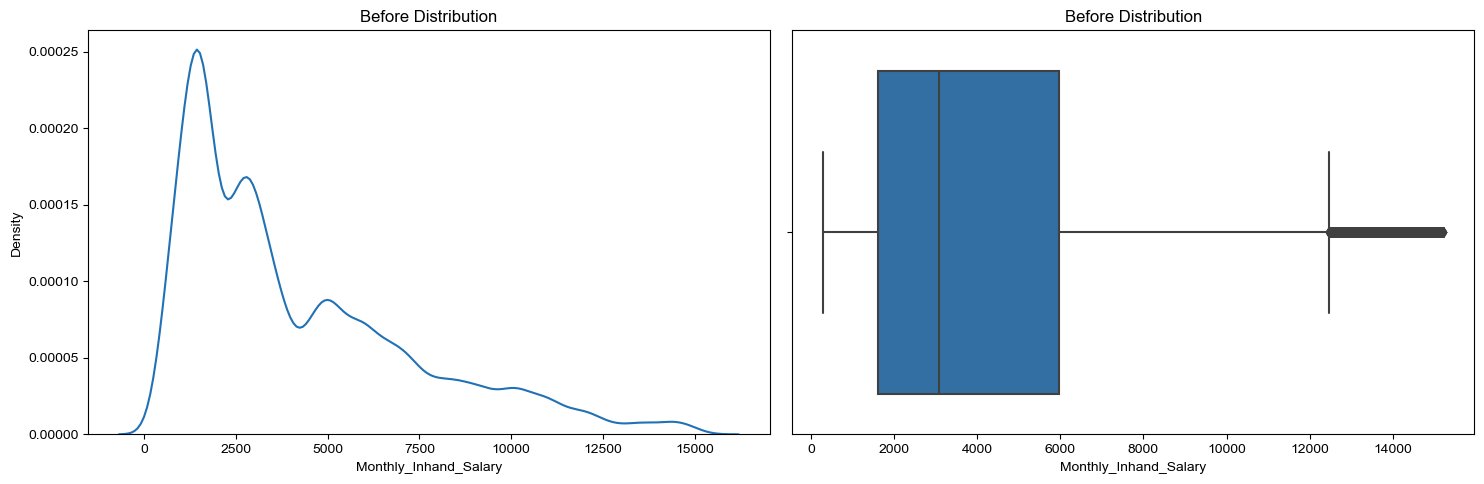

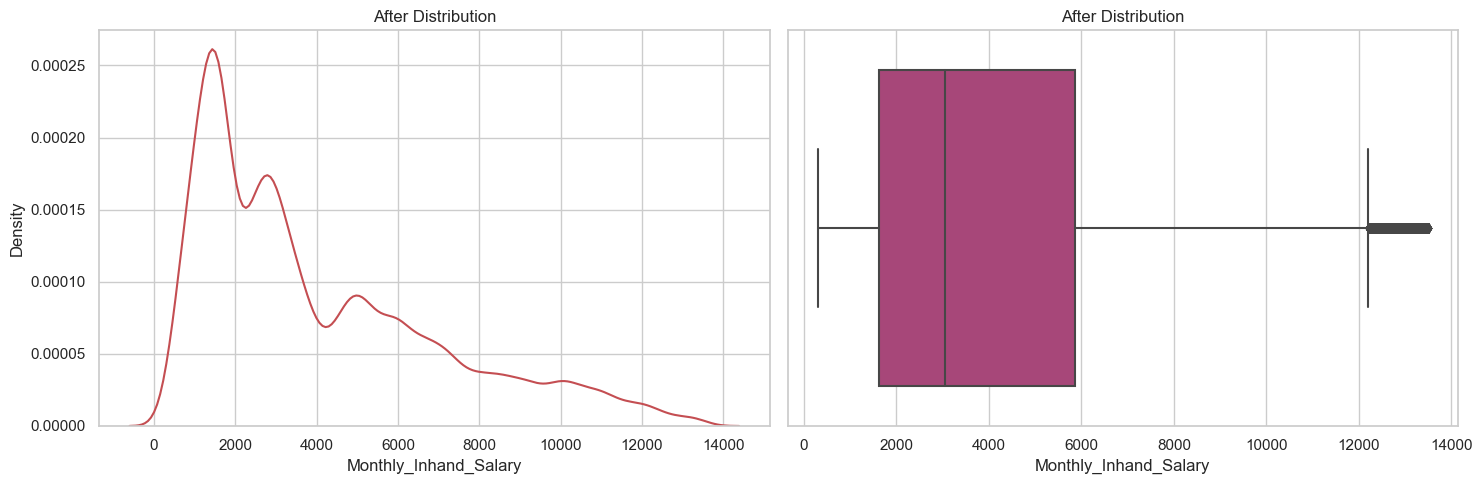

In [12]:
Distribution2(columne='Monthly_Inhand_Salary',data=data,i=0)
def get_Monthly_Inhand_Salary(row):
    if pd.isnull(row['Monthly_Inhand_Salary']):
        Monthly_Inhand_Salary=(data[data['Customer_ID']==row['Customer_ID']]['Monthly_Inhand_Salary'].dropna()).mode()
        try:
            return Monthly_Inhand_Salary[0]
        except:
            return np.NaN
    else:
        return row['Monthly_Inhand_Salary']
data['Monthly_Inhand_Salary']=data.apply(get_Monthly_Inhand_Salary,axis=1)
print(data[data['Monthly_Inhand_Salary']>= 13500].shape)
data=data[data.Monthly_Inhand_Salary < 13500]
data.shape
Distribution2(columne='Monthly_Inhand_Salary',data=data,i=1)

(703, 27)
(624, 27)


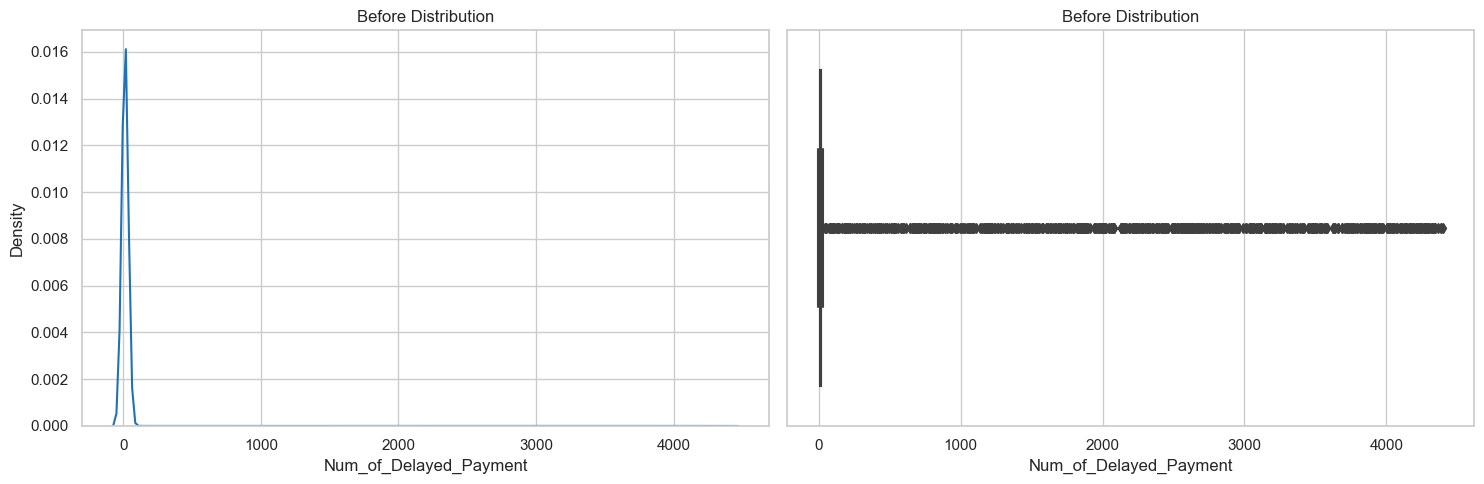

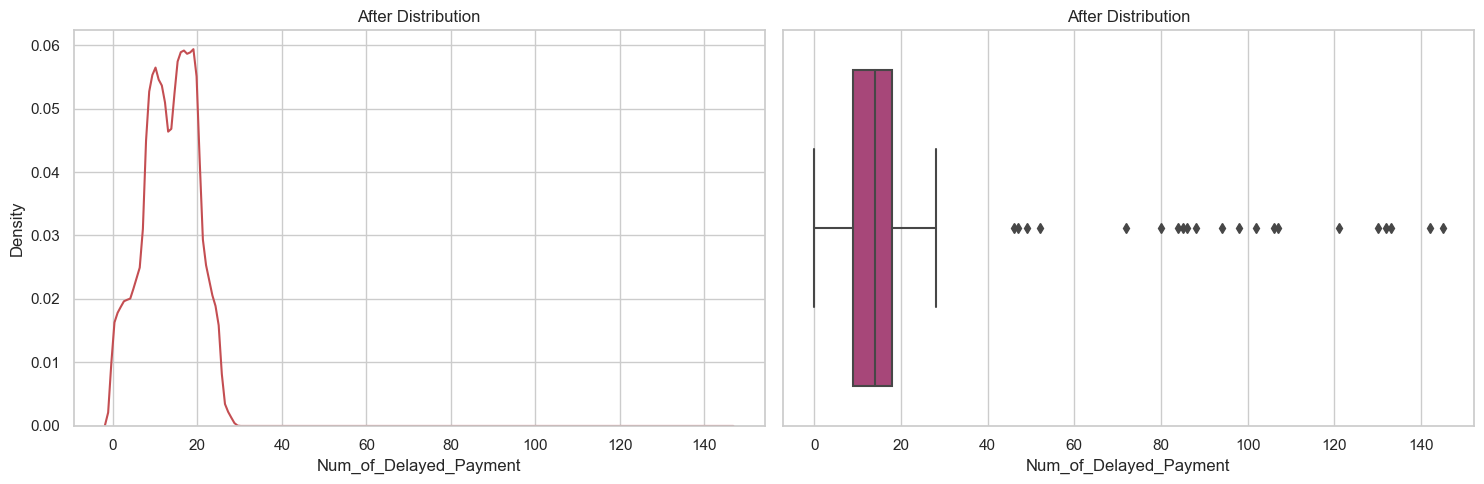

In [13]:
Distribution2(columne='Num_of_Delayed_Payment',data=data,i=0)
def get_Num_of_Delayed_Payment(row):
    if pd.isnull(row['Num_of_Delayed_Payment']):
        Num_of_Delayed_Payment=(data[data['Customer_ID']==row['Customer_ID']]['Num_of_Delayed_Payment'].dropna()).mode()
        try:
            return Num_of_Delayed_Payment[0]
        except:
            return np.NaN
    else:
        return row['Num_of_Delayed_Payment']
data['Num_of_Delayed_Payment']=data.apply(get_Num_of_Delayed_Payment,axis=1)
print(data[data['Num_of_Delayed_Payment']>=150].shape)
print(data[data['Num_of_Delayed_Payment'] < 0].shape)
data=data[data['Num_of_Delayed_Payment']< 150]
data=data[data['Num_of_Delayed_Payment'] >= 0]
Distribution2(columne='Num_of_Delayed_Payment',data=data,i=1)

(254, 27)


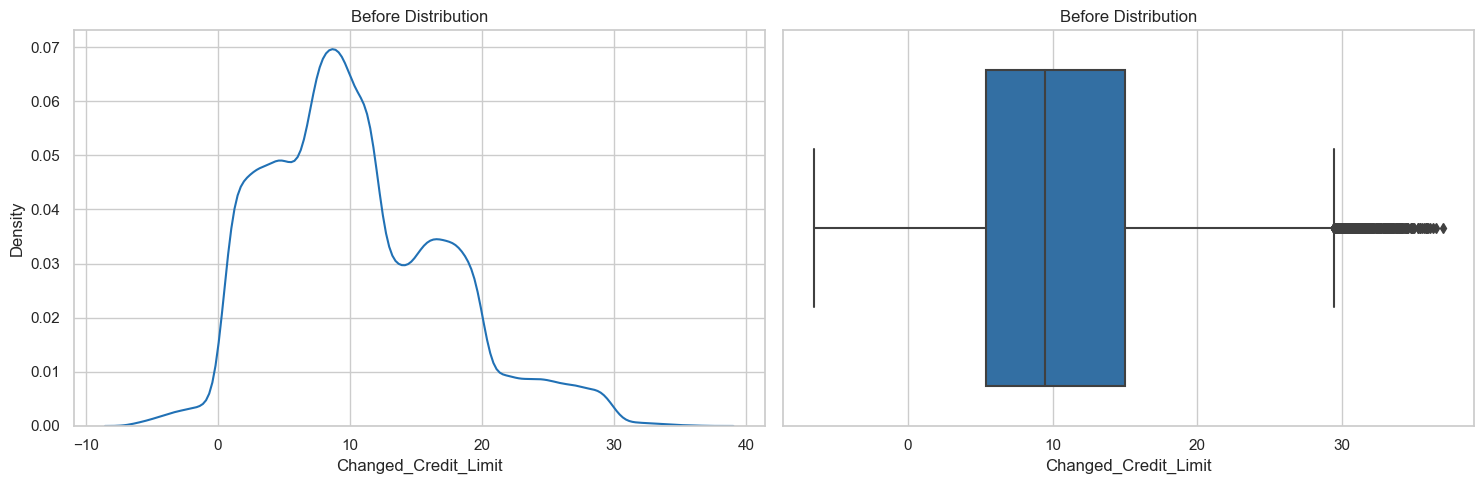

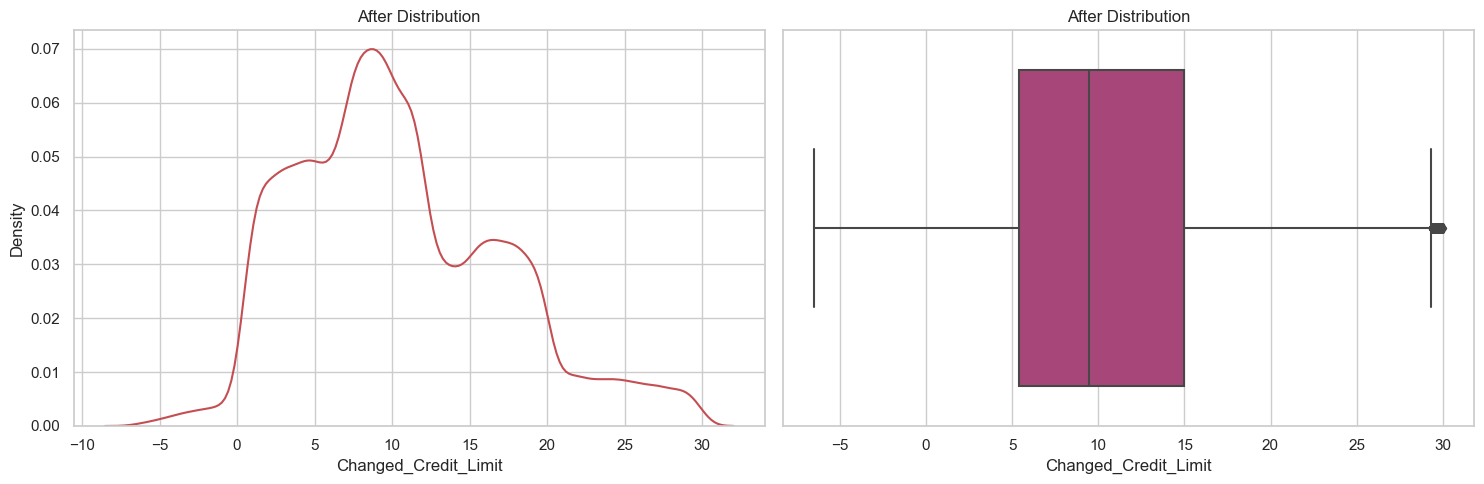

In [14]:
Distribution2(columne='Changed_Credit_Limit',data=data,i=0)
def get_Changed_Credit_Limit(row):
    if pd.isnull(row['Changed_Credit_Limit']):
        Changed_Credit_Limit=(data[data['Customer_ID']==row['Customer_ID']]['Changed_Credit_Limit'].dropna()).mode()
        try:
            return Changed_Credit_Limit[0]
        except:
            return np.NaN
    else:
        return row['Changed_Credit_Limit']
data['Changed_Credit_Limit']=data.apply(get_Changed_Credit_Limit,axis=1)
print(data[data['Changed_Credit_Limit']>=30].shape)
data=data[data['Changed_Credit_Limit'] < 30]
Distribution2(columne='Changed_Credit_Limit',data=data,i=1)

(1590, 27)


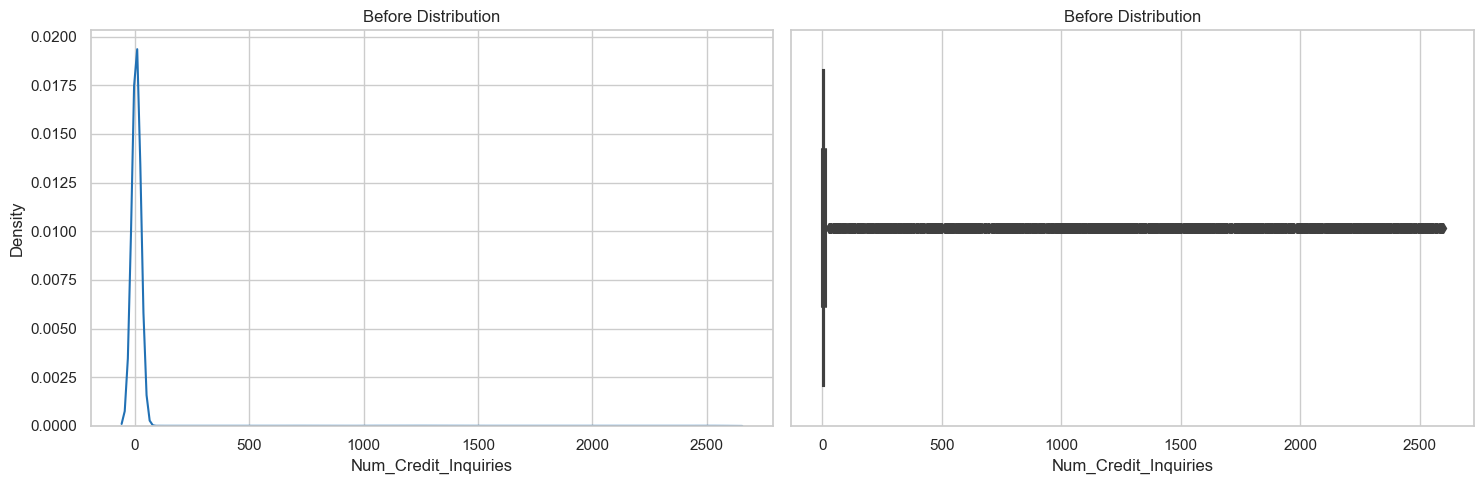

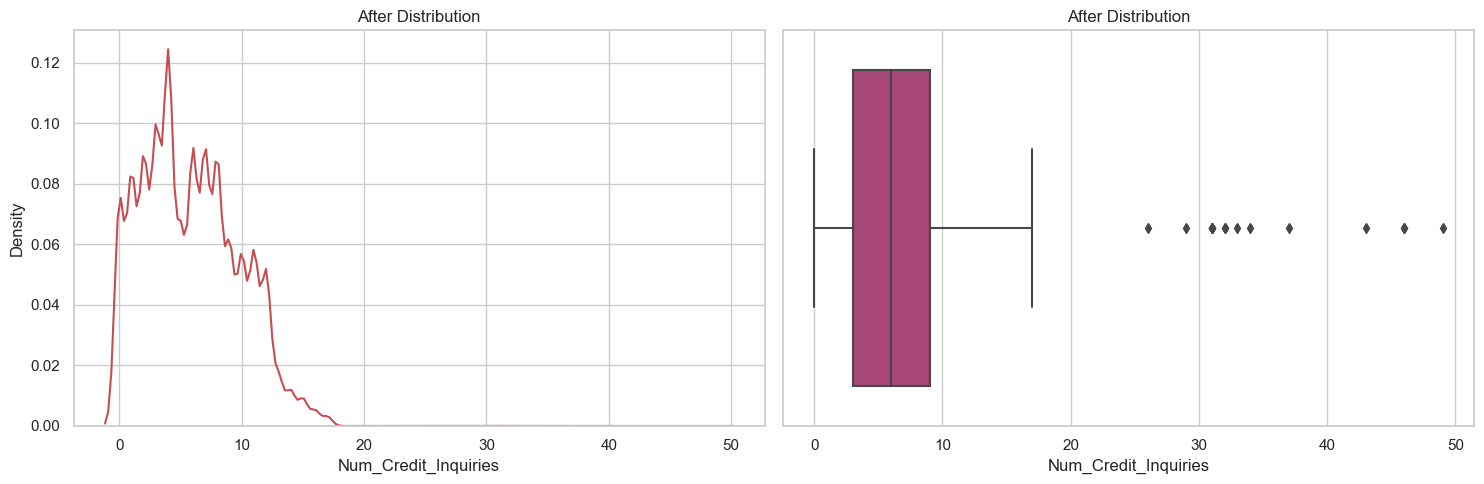

In [15]:
Distribution2(columne='Num_Credit_Inquiries',data=data,i=0)
def get_Num_Credit_Inquiries(row):
    if pd.isnull(row['Num_Credit_Inquiries']):
        Num_Credit_Inquiries=(data[data['Customer_ID']==row['Customer_ID']]['Num_Credit_Inquiries'].dropna()).mode()
        try:
            return Num_Credit_Inquiries[0]
        except:
            return np.NaN
    else:
        return row['Num_Credit_Inquiries']
data['Num_Credit_Inquiries']=data.apply(get_Num_Credit_Inquiries,axis=1)
print(data[data['Num_Credit_Inquiries']>=50].shape)
data=data[data['Num_Credit_Inquiries']<50]
Distribution2(columne='Num_Credit_Inquiries',data=data,i=1)

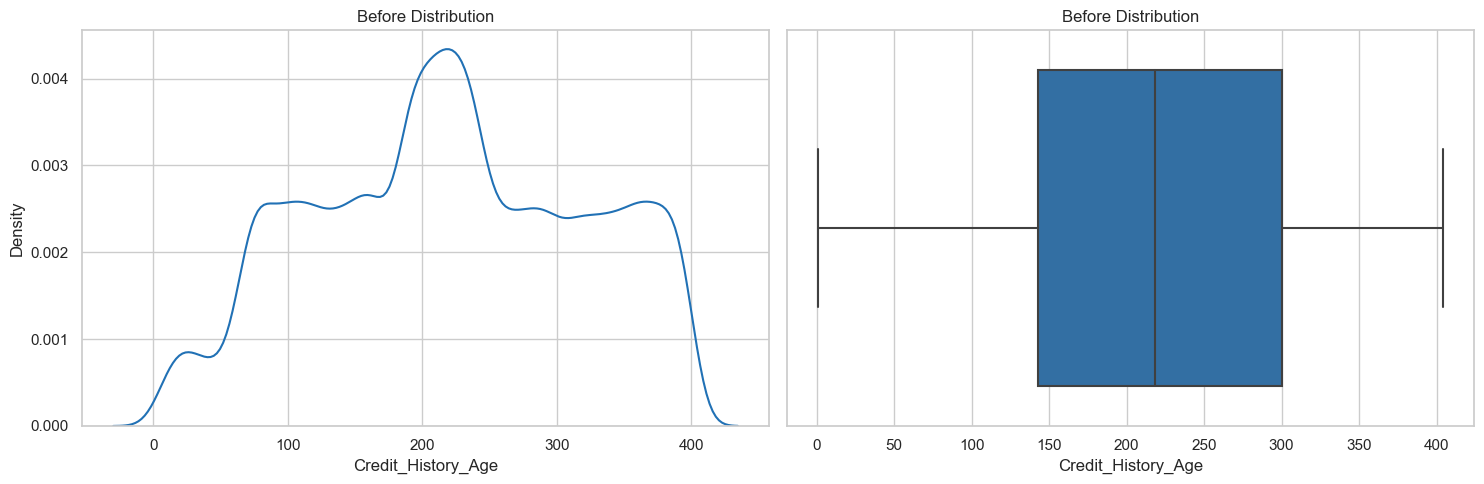

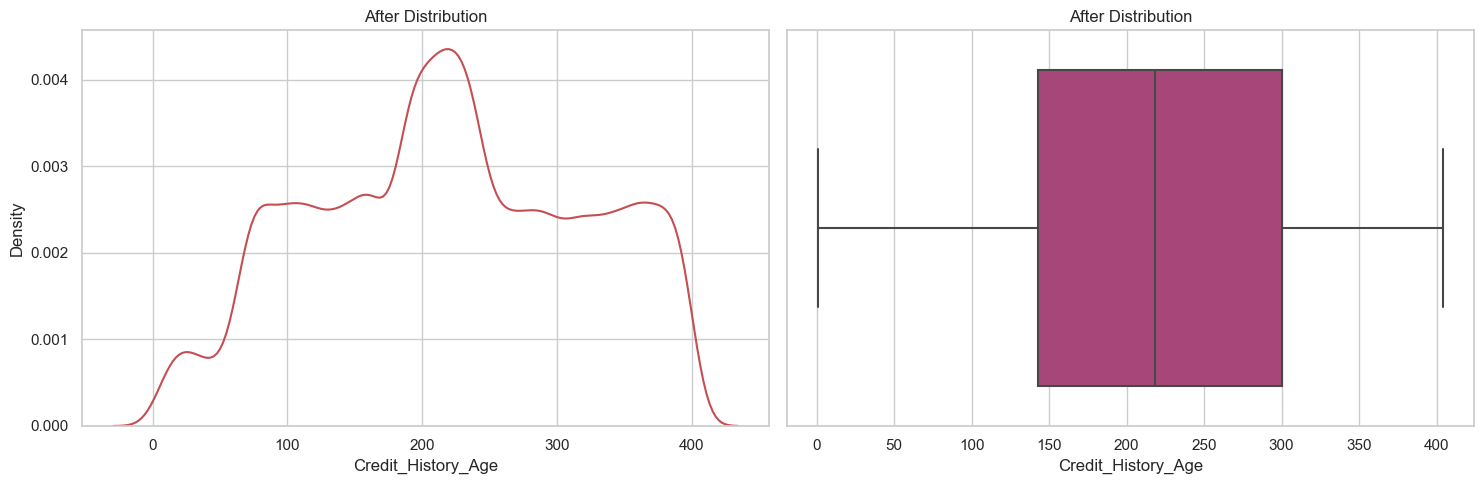

In [16]:
Distribution2(columne='Credit_History_Age',data=data,i=0)
def get_Credit_History_Age(row):
    if pd.isnull(row['Credit_History_Age']):
        Credit_History_Age=(data[data['Customer_ID']==row['Customer_ID']]['Credit_History_Age'].dropna()).mode()
        try:
            return Credit_History_Age[0]
        except:
            return np.NaN
    else:
        return row['Credit_History_Age']
data['Credit_History_Age']=data.apply(get_Credit_History_Age,axis=1)
Distribution2(columne='Credit_History_Age',data=data,i=1)


(4907, 27)


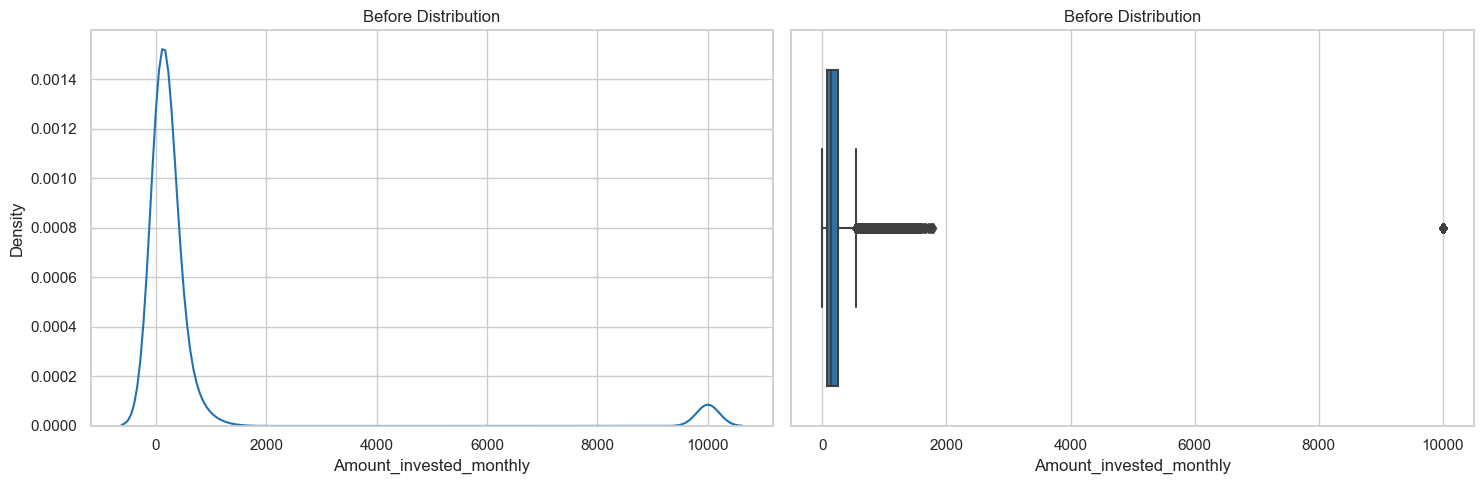

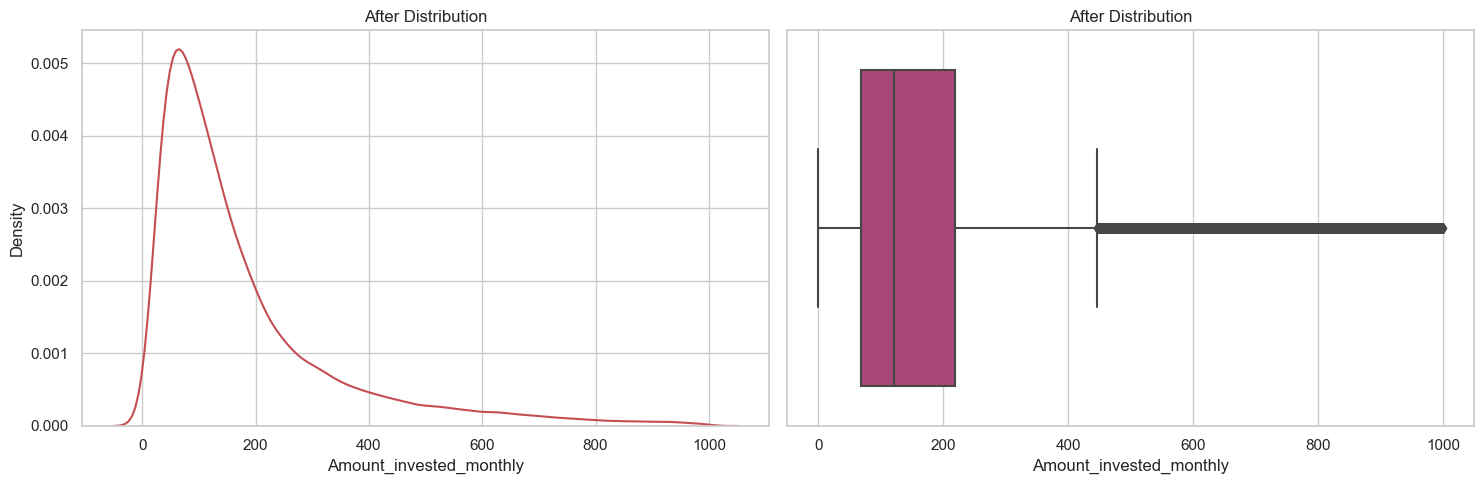

In [17]:
Distribution2(columne='Amount_invested_monthly',data=data,i=0)
def get_Amount_invested_monthly(row):
    if pd.isnull(row['Amount_invested_monthly']):
        Amount_invested_monthly=(data[data['Customer_ID']==row['Customer_ID']]['Amount_invested_monthly'].dropna()).mode()
        try:
            return Amount_invested_monthly[0]
        except:
            return np.NaN
    else:
        return row['Amount_invested_monthly']
data['Amount_invested_monthly']=data.apply(get_Amount_invested_monthly,axis=1)
print(data[data['Amount_invested_monthly']>=1000].shape)
data=data[data['Amount_invested_monthly']<1000]
Distribution2(columne='Amount_invested_monthly',data=data,i=1)


(9, 27)


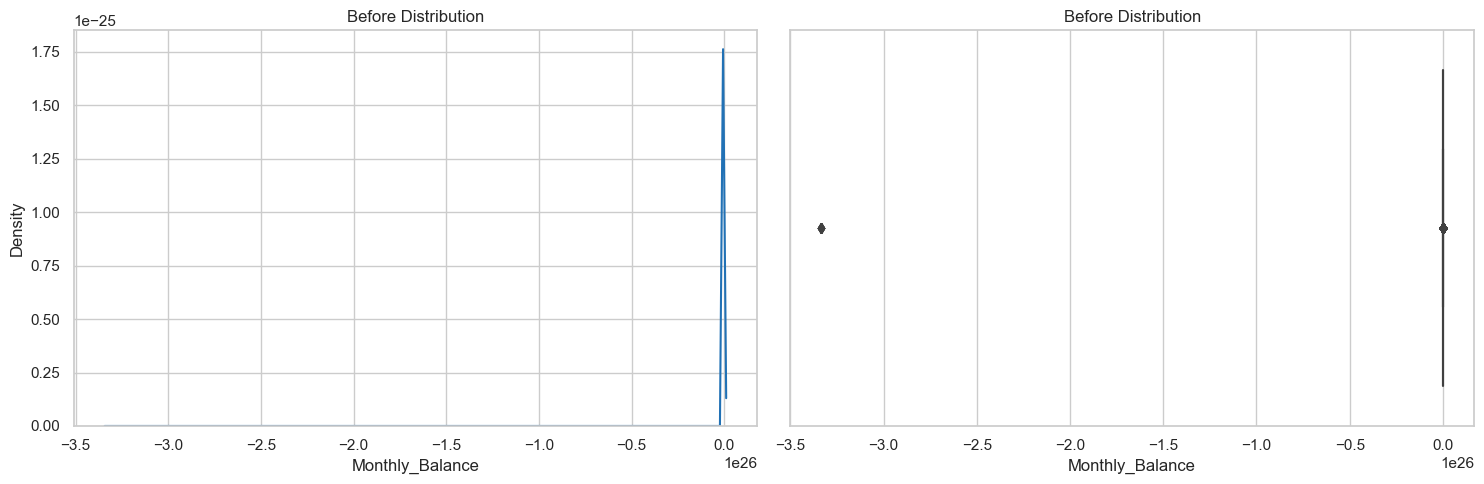

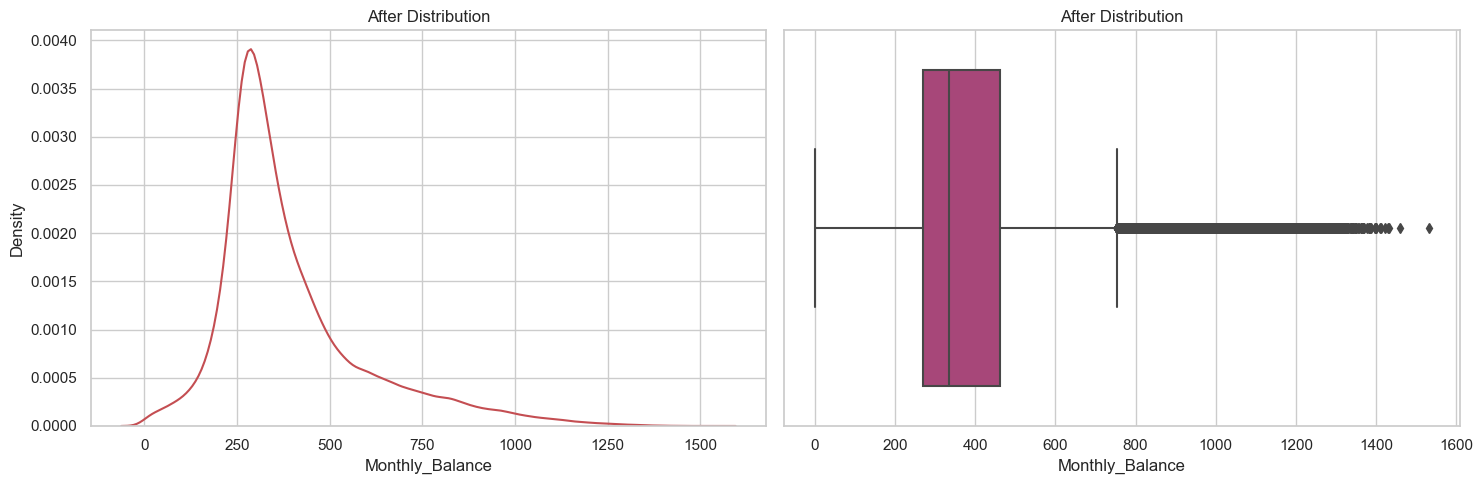

In [18]:
Distribution2(columne='Monthly_Balance',data=data,i=0)
def get_Monthly_Balance(row):
    if pd.isnull(row['Monthly_Balance']):
        Monthly_Balance=(data[data['Customer_ID']==row['Customer_ID']]['Monthly_Balance'].dropna()).mode()
        try:
            return Monthly_Balance[0]
        except:
            return np.NaN
    else:
        return row['Monthly_Balance']
data['Monthly_Balance']=data.apply(get_Monthly_Balance,axis=1)
print(data[data['Monthly_Balance'] <= 0].shape)
data = data[data['Monthly_Balance'] > 0]
Distribution2(columne='Monthly_Balance',data=data,i=1)


## More

In [19]:
def get_Occupation(row):
    if pd.isnull(row['Occupation']):
        Occupation=(data[data['Customer_ID']==row['Customer_ID']]['Occupation'].dropna()).mode()
        try:
            return Occupation[0]
        except:
            return np.NaN
    else:
        return row['Occupation']
data['Occupation']=data.apply(get_Occupation,axis=1)
data['Occupation'] = data['Occupation'].fillna(data['Occupation'].mode()[0])
len(data[data['Occupation'].isnull()])

0

In [21]:
# print(data.head(2))
data['Type_of_Loan'] = data['Type_of_Loan'].fillna('Not Specified')
def get_Diff_Values_Colum(df_data):
    valu=['Auto Loan','Credit-Builder Loan','Debt Consolidation Loan','Home Equity Loan','Mortgage Loan','Not Specified',
          'Payday Loan','Personal Loan','Student Loan']
    for x in valu:
        df_data[x] = np.NAN
        
    index=0
    for i in df_data['Type_of_Loan']:
        diff_value=[]
        if  ',' not in i:
            diff_value.append(i.strip())
        else:
            for data in map(lambda x:x.strip(), i.replace('and','').split(',')):
                if not data in diff_value:
                    diff_value.append(data)
        
        for x in valu:
            if x in diff_value:
                df_data[x].iloc[index]=1
        index=index+1
        
    for x in valu:
        df_data[x] = df_data[x].fillna(0)
        df_data[x] = df_data[x].astype(int) 
    return df_data

data=get_Diff_Values_Colum(data)
data.drop('Type_of_Loan',axis=1,inplace=True)

In [22]:
def get_Credit_Mix(row):
    if pd.isnull(row['Credit_Mix']):
        Credit_Mix=(data[data['Customer_ID']==row['Customer_ID']]['Credit_Mix'].dropna()).mode()
        try:
            return Credit_Mix[0]
        except:
            return np.NaN
    else:
        return row['Credit_Mix']
data['Credit_Mix']=data.apply(get_Credit_Mix,axis=1)
data['Credit_Mix'] = data['Credit_Mix'].fillna(data['Credit_Mix'].mode()[0])
len(data[data['Credit_Mix'].isnull()])

0

In [23]:
def get_Payment_Behaviour(row):
    if pd.isnull(row['Payment_Behaviour']):
        Payment_Behaviour=(data[data['Customer_ID']==row['Customer_ID']]['Payment_Behaviour'].dropna()).mode()
        try:
            return Payment_Behaviour[0]
        except:
            return np.NaN
    else:
        return row['Payment_Behaviour']
data['Payment_Behaviour']=data.apply(get_Payment_Behaviour,axis=1)
data['Payment_Behaviour'] = data['Payment_Behaviour'].fillna(data['Payment_Behaviour'].mode()[0])
len(data[data['Payment_Behaviour'].isnull()])

0

In [24]:
columns_with_missing_values(data)

Name    9035
dtype: int64

In [25]:
num_columns = list(data.select_dtypes(include=["int64","float64",'int32']).columns)
num_columns=num_columns[2:-9]
process=['Monthly_Inhand_Salary','Num_of_Delayed_Payment','Changed_Credit_Limit','Num_Credit_Inquiries',
         'Credit_History_Age','Amount_invested_monthly','Monthly_Balance']
for i in num_columns:
    if i not in process:
        print(i)

Age
Annual_Income
Num_Bank_Accounts
Num_Credit_Card
Interest_Rate
Num_of_Loan
Delay_from_due_date
Outstanding_Debt
Credit_Utilization_Ratio
Total_EMI_per_month


(1714, 35)


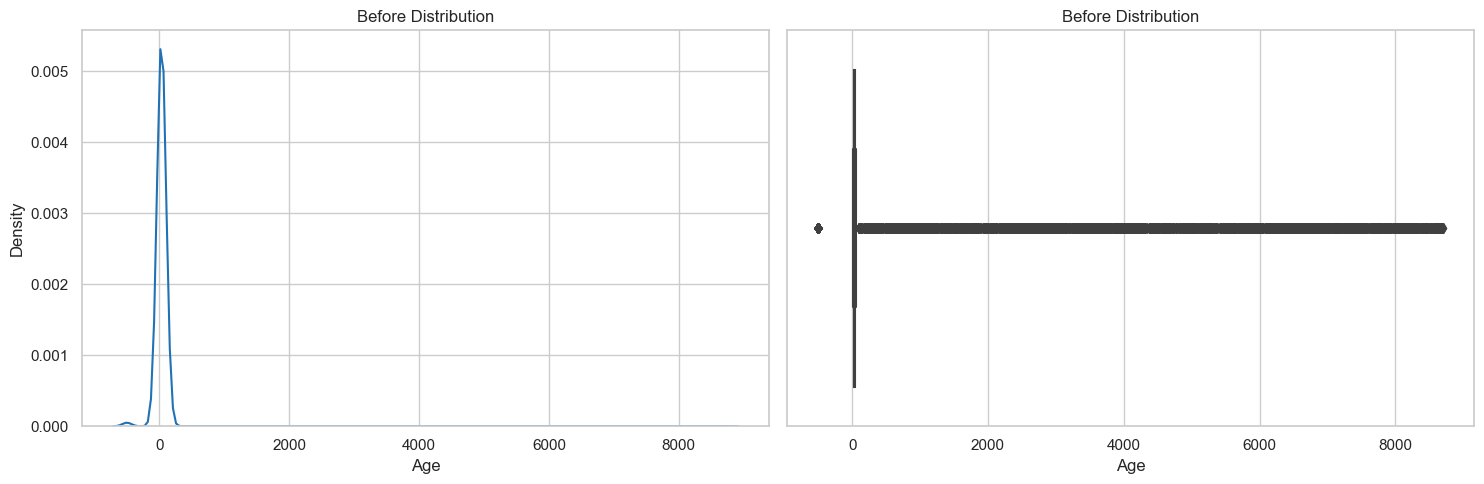

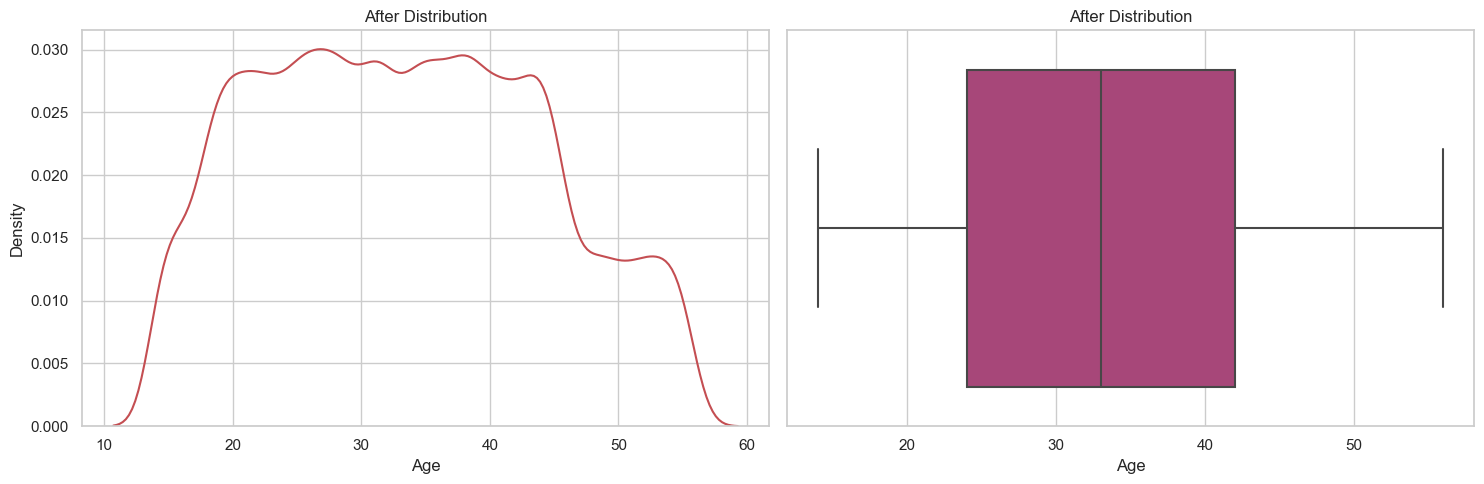

In [26]:
Distribution2(columne='Age',data=data,i=0)
print(data[data['Age'] > 60].shape)
def get_age(row):
    if (60 < row['Age']) or (0 > row['Age']) :
        Age=(data[data['Customer_ID']==row['Customer_ID']]['Age'].dropna()).mode()
        try:
            return Age[0]
        except:
            return np.NaN
    else:
        return row['Age']
data['Age']=data.apply(get_age,axis=1)
data[data['Age'] > 60].sort_values('Age')
data.drop(data[data['Age'] > 60].index,axis=0,inplace=True)
data[data['Age'] < 0].sort_values('Age')
data.drop(data[data['Age']  < 0].index,axis=0,inplace=True)
Distribution2(columne='Age',data=data,i=1)

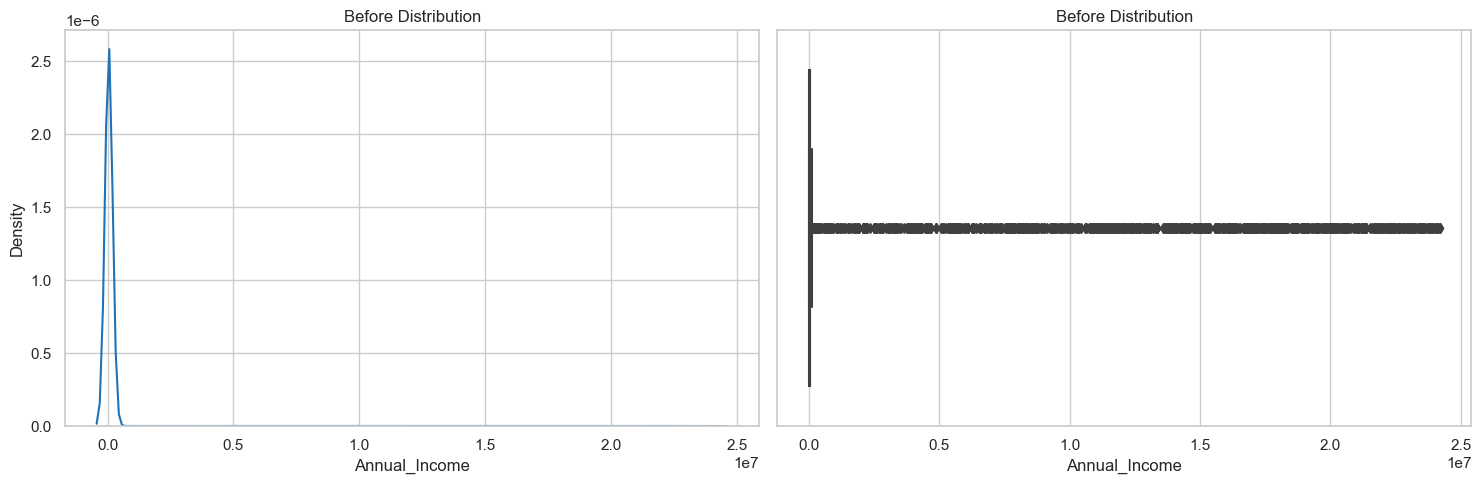

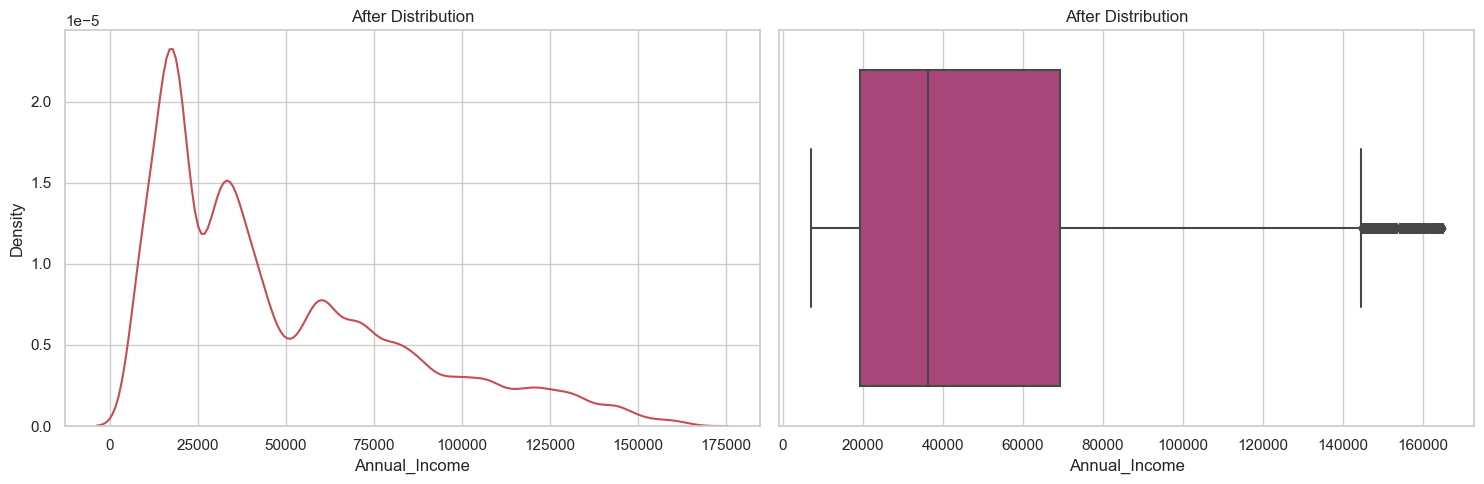

In [27]:
Distribution2(columne='Annual_Income',data=data,i=0)
def get_Annual_Income(row):
    if 150000 < row['Annual_Income'] :
        Annual_Income=(data[data['Customer_ID']==row['Customer_ID']]['Annual_Income'].dropna()).mode()
        try:
            return Annual_Income[0]
        except:
            return np.NaN
    else:
        return row['Annual_Income']
data['Annual_Income']=data.apply(get_Annual_Income,axis=1)
data[data['Annual_Income'] > 165000].sort_values('Annual_Income')
data.drop(data[data['Annual_Income']  > 165000].index,axis=0,inplace=True)
Distribution2(columne='Annual_Income',data=data,i=1)

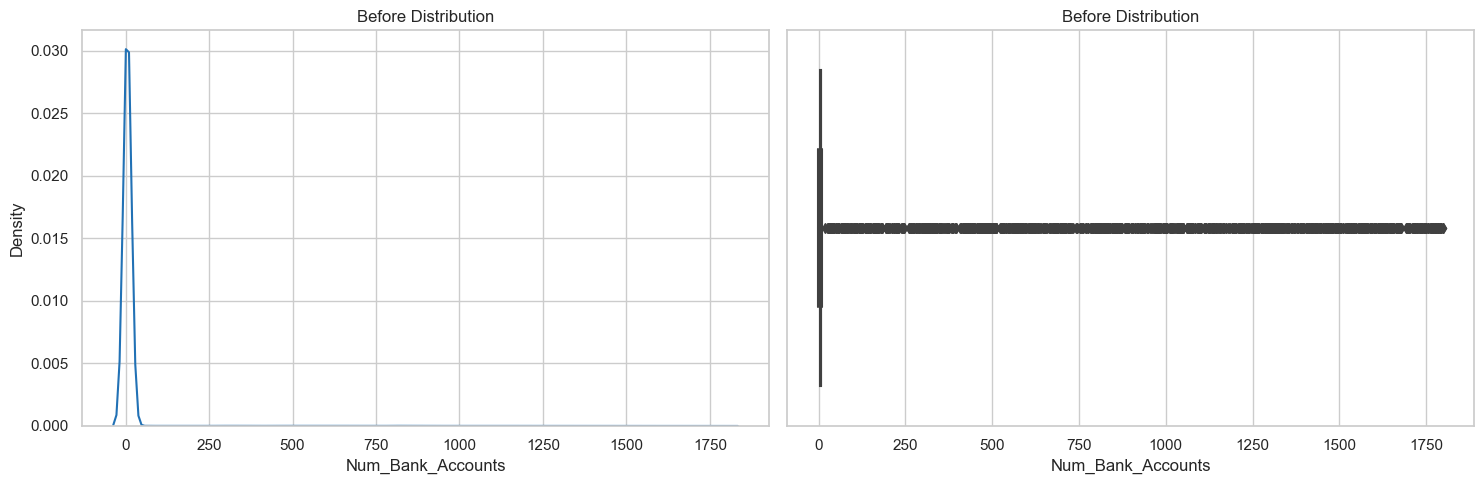

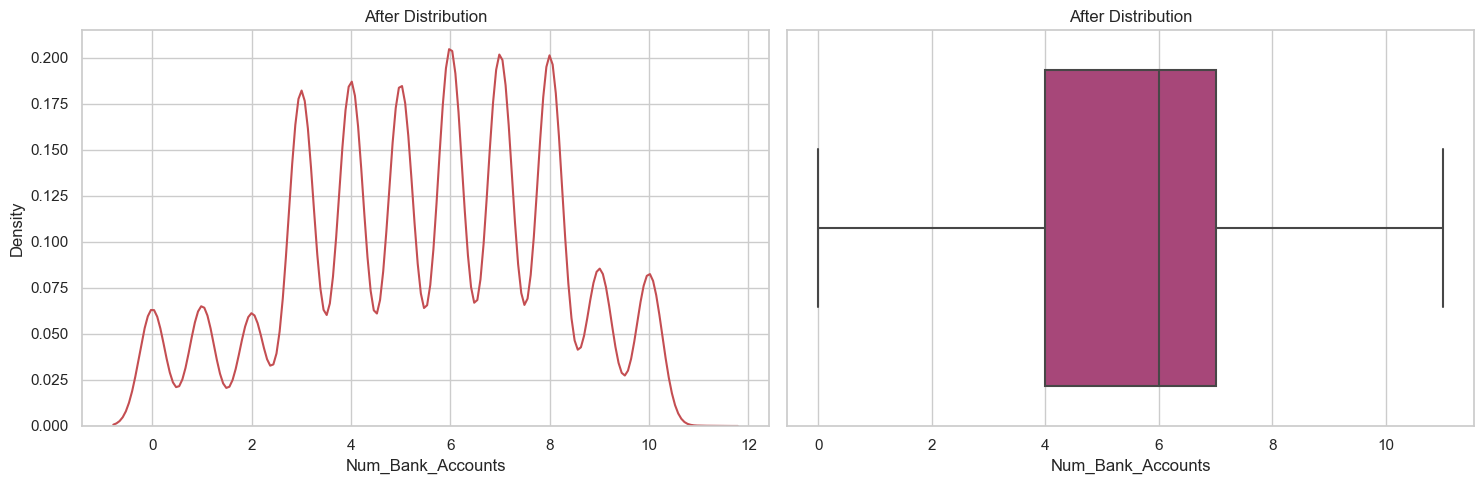

In [28]:
Distribution2(columne='Num_Bank_Accounts',data=data,i=0)
def get_Num_Bank_Accounts(row):
    if 12 < row['Num_Bank_Accounts'] :
        Num_Bank_Accounts=(data[data['Customer_ID']==row['Customer_ID']]['Num_Bank_Accounts'].dropna()).mode()
        try:
            return Num_Bank_Accounts[0]
        except:
            return np.NaN
    else:
        return row['Num_Bank_Accounts']
data['Num_Bank_Accounts']=data.apply(get_Num_Bank_Accounts,axis=1)
data.drop(data[data['Num_Bank_Accounts']  > 12].index,axis=0,inplace=True)
data.drop(data[data['Num_Bank_Accounts']  < 0].index,axis=0,inplace=True)
Distribution2(columne='Num_Bank_Accounts',data=data,i=1)


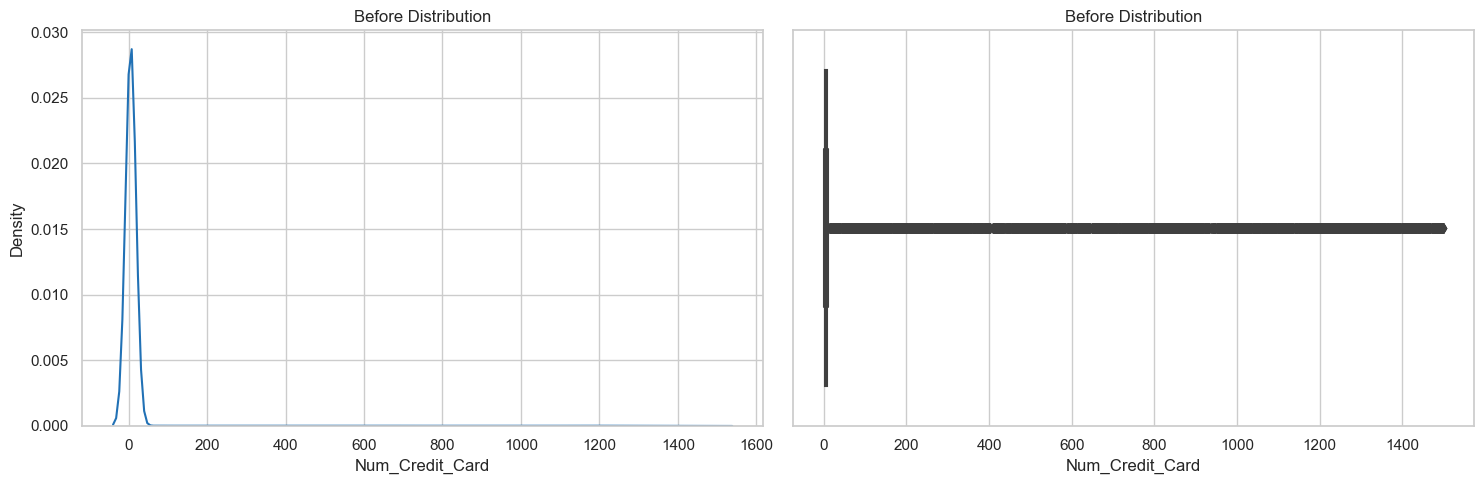

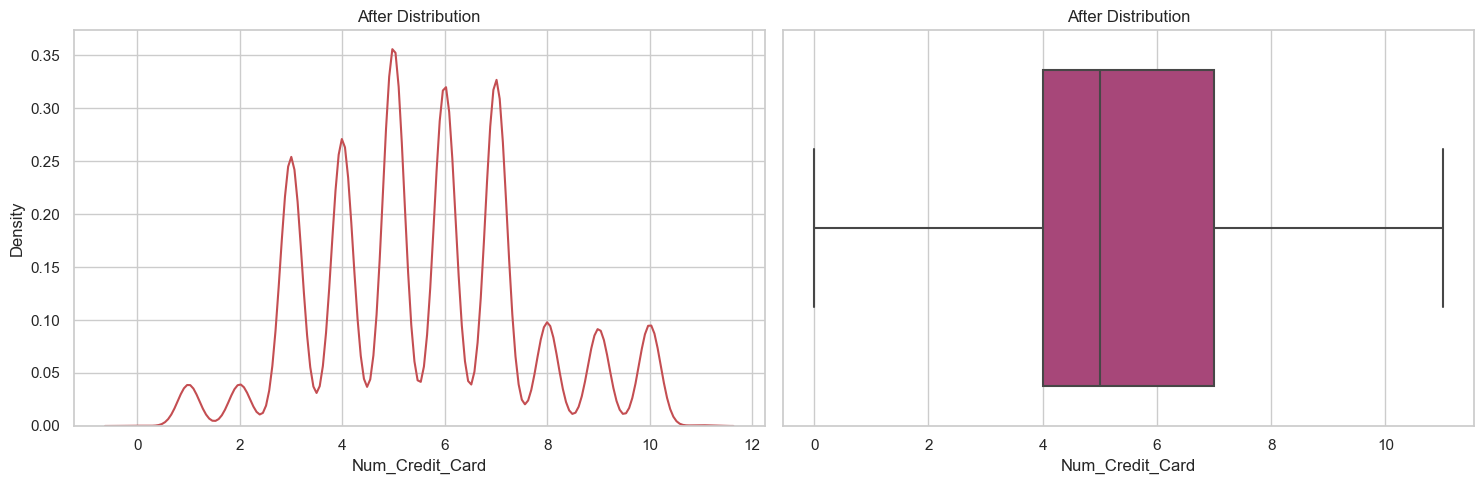

In [29]:
Distribution2(columne='Num_Credit_Card',data=data,i=0)
def get_Num_Credit_Card(row):
    if 14 < row['Num_Credit_Card'] :
        Num_Credit_Card=(data[data['Customer_ID']==row['Customer_ID']]['Num_Credit_Card'].dropna()).mode()
        try:
            return Num_Credit_Card[0]
        except:
            return np.NaN
    else:
        return row['Num_Credit_Card']
data['Num_Credit_Card']=data.apply(get_Num_Credit_Card,axis=1)
data.drop(data[data['Num_Credit_Card']  > 14].index,axis=0,inplace=True)
Distribution2(columne='Num_Credit_Card',data=data,i=1)


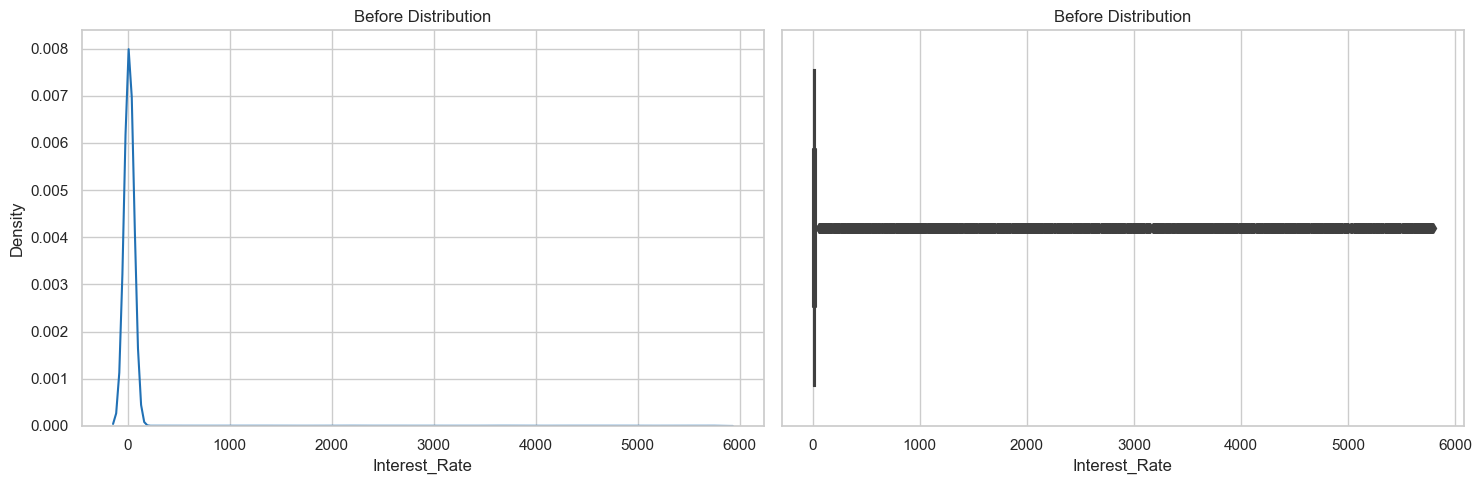

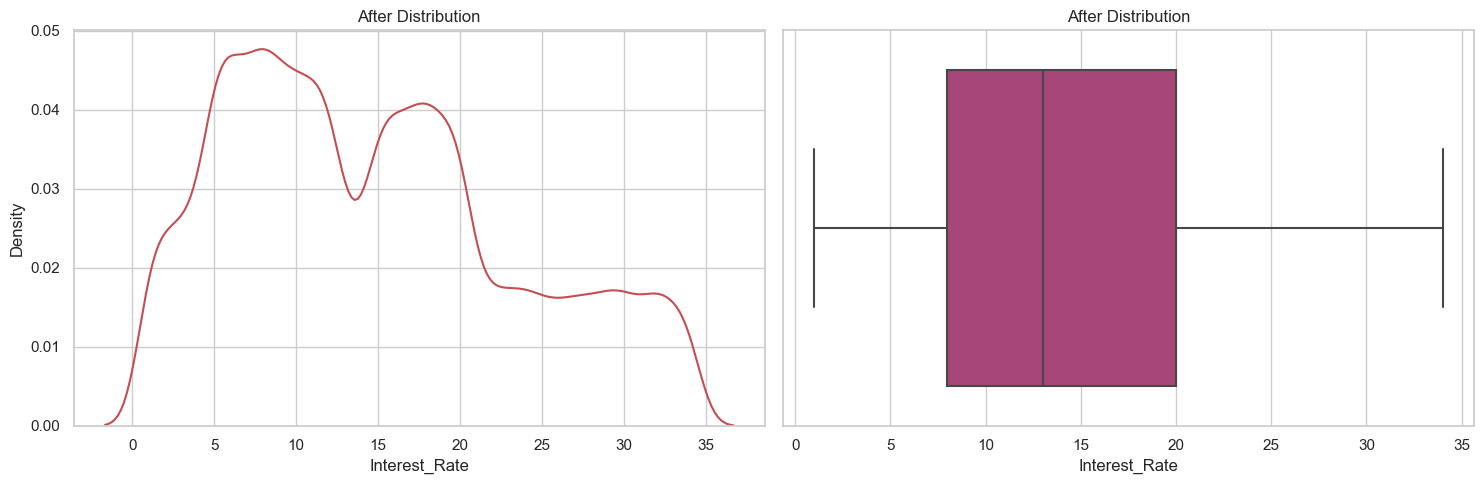

In [30]:
Distribution2(columne='Interest_Rate',data=data,i=0)
data[data['Interest_Rate'] > 35].sort_values('Interest_Rate')
def get_Interest_Rate(row):
    if 35 < row['Interest_Rate'] :
        Interest_Rate=(data[data['Customer_ID']==row['Customer_ID']]['Interest_Rate'].dropna()).mode()
        try:
            return Interest_Rate[0]
        except:
            return np.NaN
    else:
        return row['Interest_Rate']
data['Interest_Rate']=data.apply(get_Interest_Rate,axis=1)
Distribution2(columne='Interest_Rate',data=data,i=1)


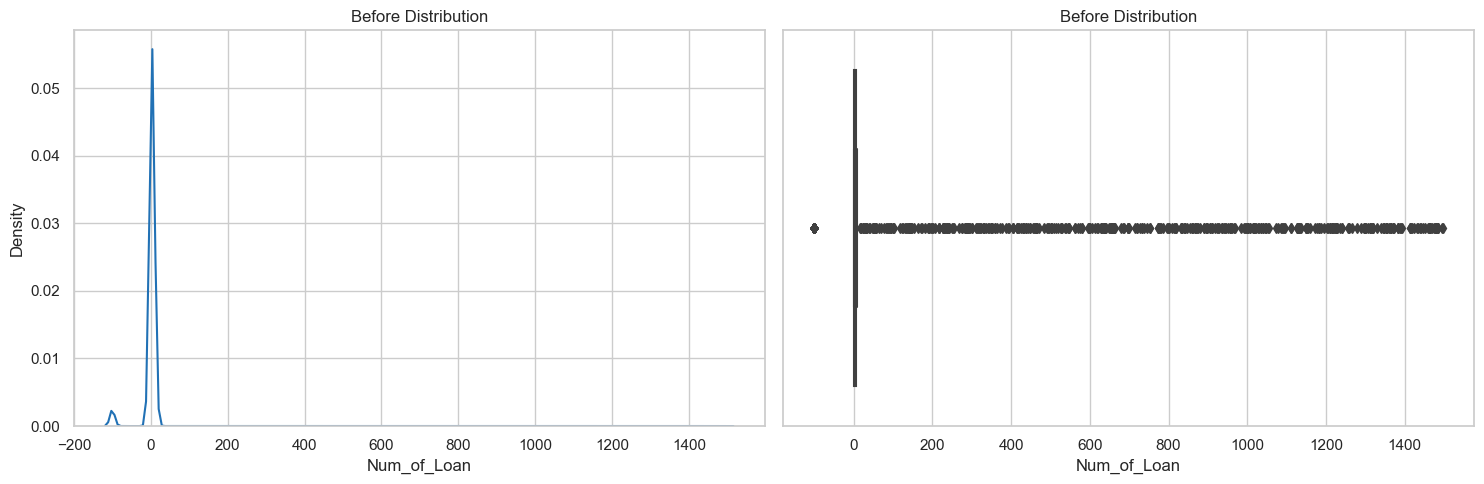

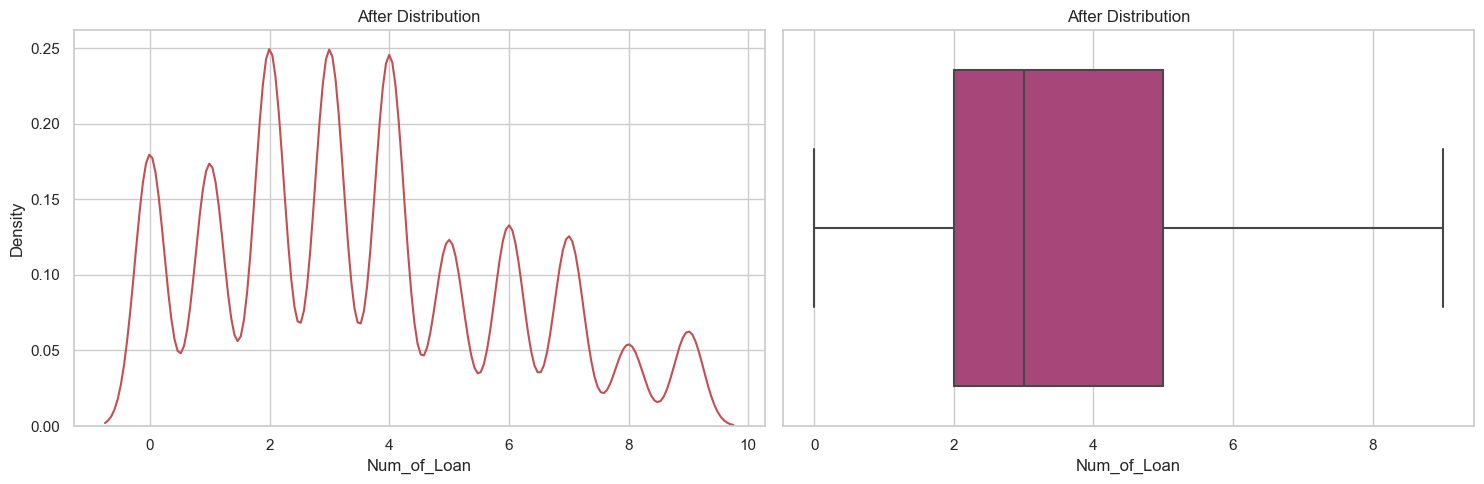

In [31]:
Distribution2(columne='Num_of_Loan',data=data,i=0)
def get_Num_of_Loan(row):
    if (8 < row['Num_of_Loan']) or (0 > row['Num_of_Loan']):
        Num_of_Loan=(data[data['Customer_ID']==row['Customer_ID']]['Num_of_Loan'].dropna()).mode()
        try:
            return Num_of_Loan[0]
        except:
            return np.NaN
    else:
        return row['Num_of_Loan']
data['Num_of_Loan']=data.apply(get_Num_of_Loan,axis=1)
data.drop(data[data['Num_of_Loan']  < 0].index,axis=0,inplace=True)
Distribution2(columne='Num_of_Loan',data=data,i=1)


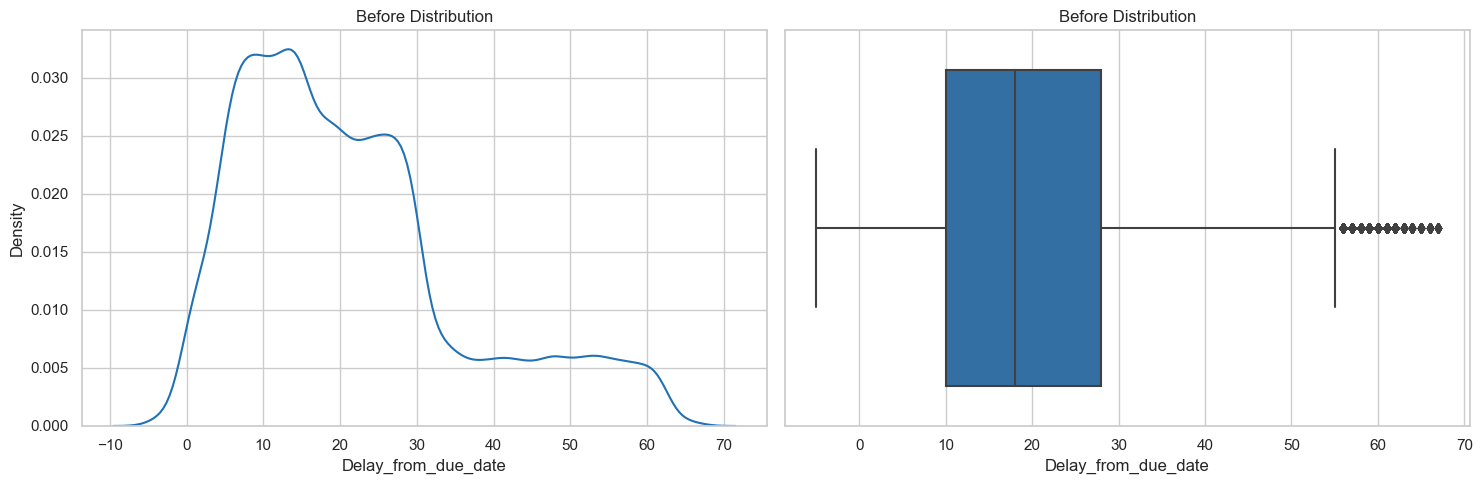

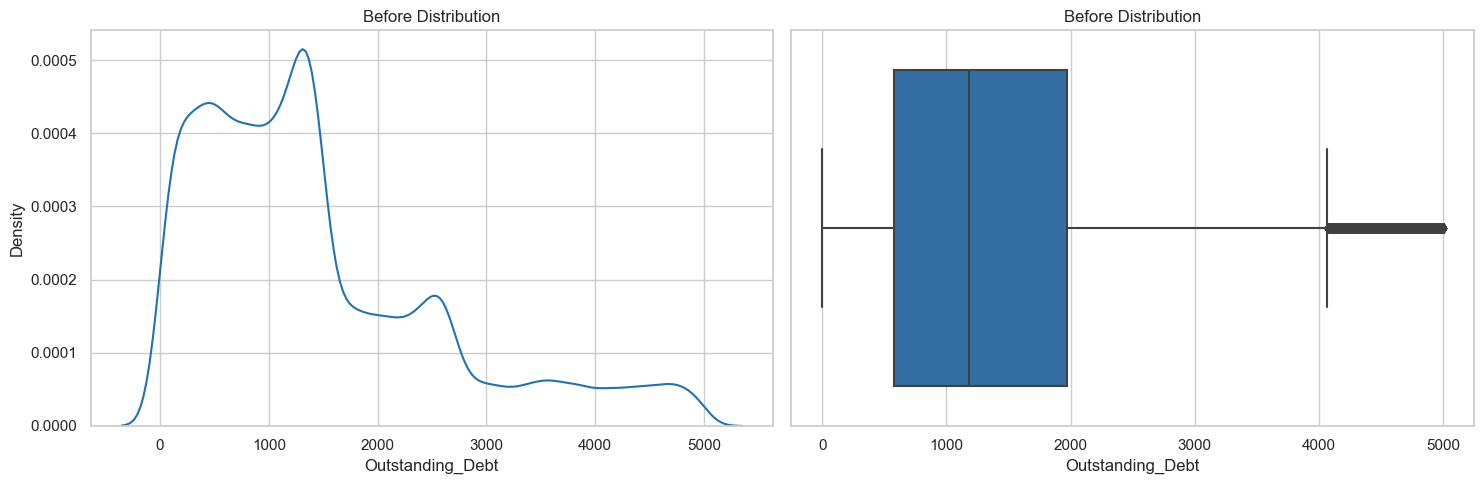

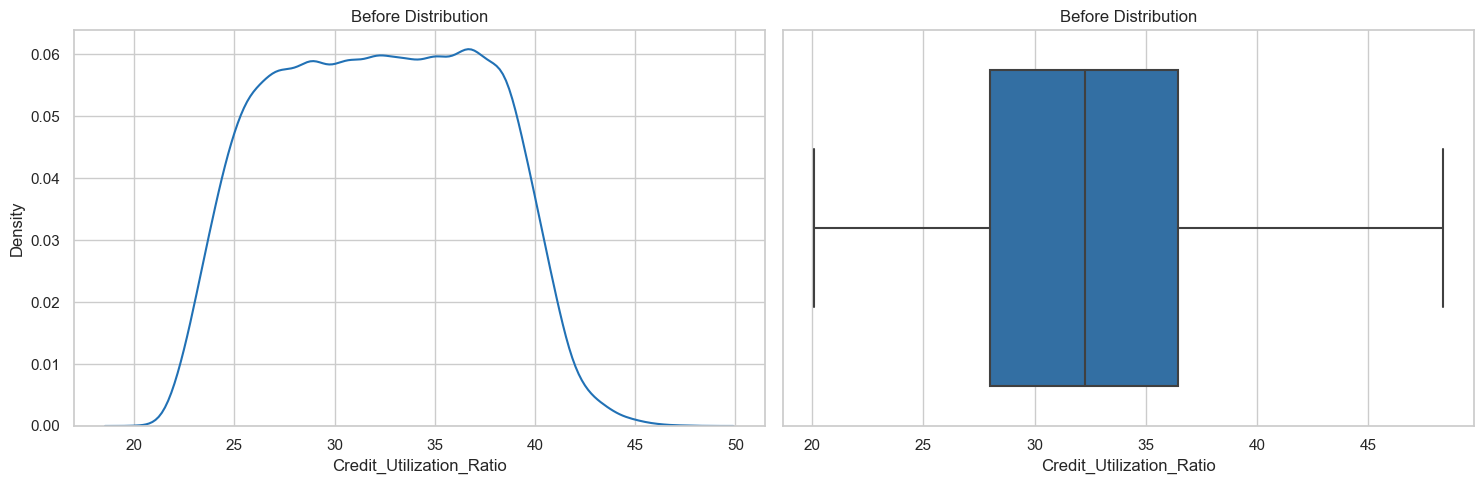

In [32]:
Distribution2(columne='Delay_from_due_date',data=data,i=0)
Distribution2(columne='Outstanding_Debt',data=data,i=0)
Distribution2(columne='Credit_Utilization_Ratio',data=data,i=0)


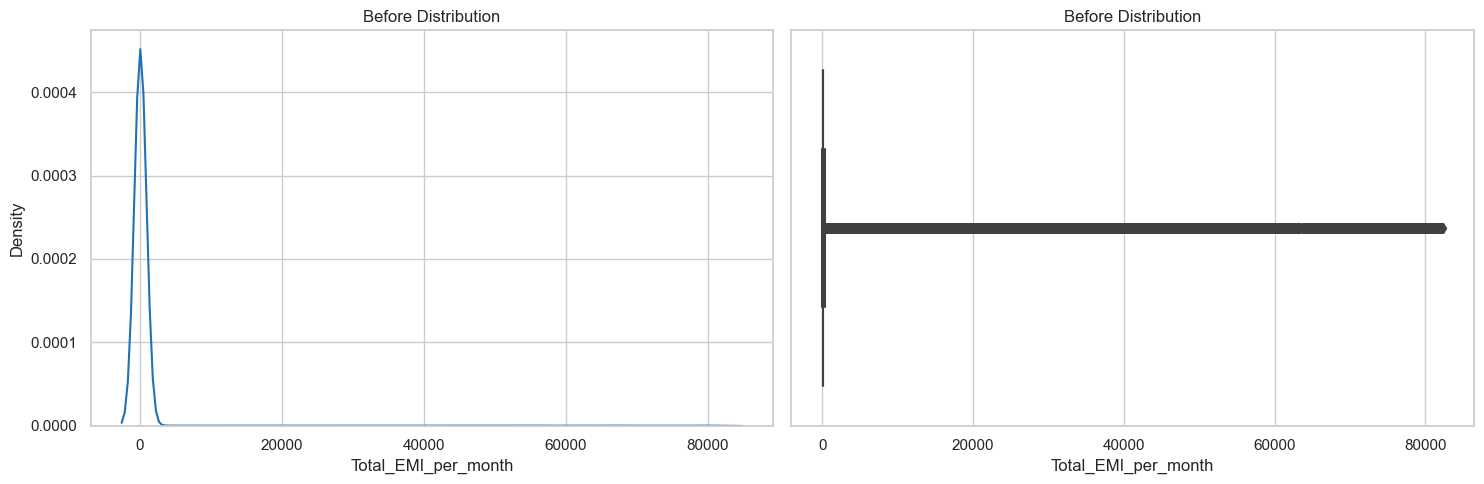

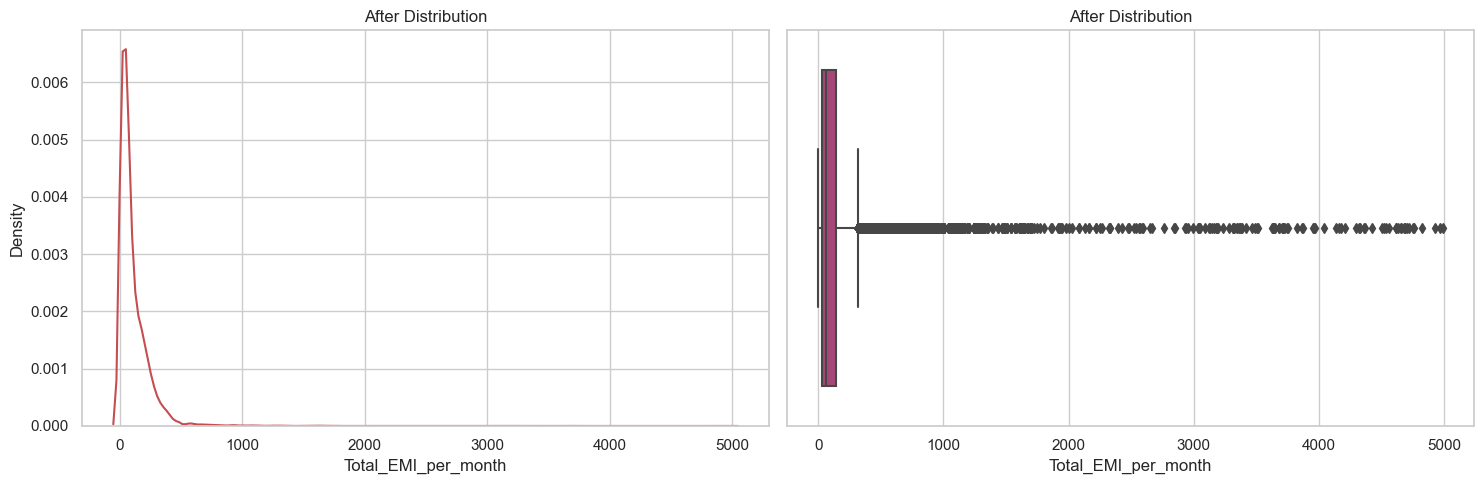

In [33]:
Distribution2(columne='Total_EMI_per_month',data=data,i=0)
data=data[data['Total_EMI_per_month']<5000]
Distribution2(columne='Total_EMI_per_month',data=data,i=1)


In [34]:
data.shape

(87865, 35)

## Data to csv

In [35]:
data.to_csv("bank_data.csv", index=False)

In [36]:
process_df= pd.read_csv("bank_data.csv",sep = "," , encoding = "utf-8")

## Drop unimportant columns

In [37]:
def drop_columns(DataFrame):
    lazy_list=['ID','Customer_ID','Name']
    DataFrame.drop(lazy_list, axis=1, inplace=True)
drop_columns(process_df)

## Encoding categorical features

In [38]:
process_df['Month'] = process_df['Month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12})
Occupation_le = LabelEncoder()

process_df['Occupation'] = Occupation_le.fit_transform(process_df['Occupation'])
Occupation_le.classes_
Credit_Mix_le = LabelEncoder()

process_df['Credit_Mix'] = Credit_Mix_le.fit_transform(process_df['Credit_Mix'])
Credit_Mix_le.classes_
Payment_Behaviour_le = LabelEncoder()

process_df['Payment_Behaviour'] = Payment_Behaviour_le.fit_transform(process_df['Payment_Behaviour'])
Payment_Behaviour_le.classes_
Payment_of_Min_Amount_le = LabelEncoder()

process_df['Payment_of_Min_Amount'] = Payment_of_Min_Amount_le.fit_transform(process_df['Payment_of_Min_Amount'])
Payment_of_Min_Amount_le.classes_

array(['NM', 'No', 'Yes'], dtype=object)

## scaling and split the data

In [39]:
x = process_df.drop('Credit_Score',axis=1)
y = process_df['Credit_Score']
y_le = LabelEncoder()

y_Encode = y_le.fit_transform(y)
y_le.classes_
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
pca = PCA(n_components=0.98)
x_reduced = pca.fit_transform(x)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))


Number of original features is 31 and of reduced features is 22


In [40]:
evals = dict()
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    evals[str(name)] = [train_accuracy, test_accuracy]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Poor', 'Standard','Good'])